In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import os
import warnings
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms, datasets

warnings.filterwarnings('ignore')

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [50]:
train_dir = '/kaggle/input/reduced/dogs-vs-cats/train'
test_dir = '/kaggle/input/reduced/dogs-vs-cats/test'

In [51]:
NUM_WORKERS = os.cpu_count()
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int = NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    full_train_data = datasets.ImageFolder(train_dir)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Split training data into training and validation sets
    train_size = int(0.9 * len(full_train_data))
    val_size = len(full_train_data) - train_size
    train_data, val_data = torch.utils.data.random_split(full_train_data, [train_size, val_size])

    # Apply transformations
    train_data.dataset.transform = transform
    val_data.dataset.transform = transform

    # Turn datasets into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Get class names
    class_names = full_train_data.classes

    return train_dataloader, val_dataloader, test_dataloader, class_names

In [52]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [53]:
BATCH_SIZE = 4


train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

print(f"Class names: {class_names}")

Class names: ['cats', 'dogs']


torch.Size([3, 224, 224]) tensor(1)


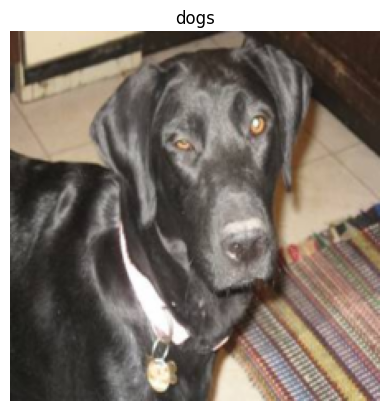

In [54]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Displaying an image from the train data loader:


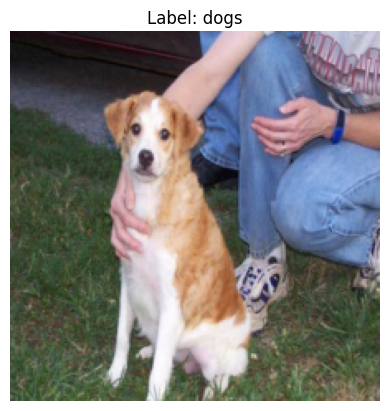

Displaying an image from the test data loader:


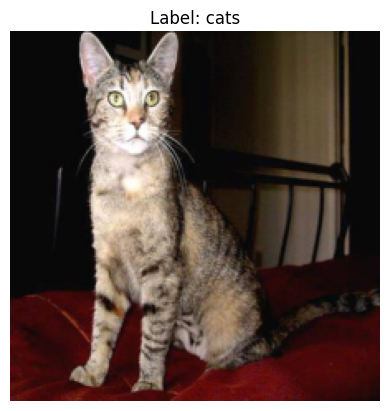

In [55]:
def show_image(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    img = np.transpose(images[0].numpy(), (1, 2, 0))
    plt.imshow(img)
    plt.title(f'Label: {class_names[labels[0]]}')
    plt.axis('off')
    plt.show()

# Display an image from the train data loader
print("Displaying an image from the train data loader:")
show_image(train_dataloader)

# Display an image from the test data loader
print("Displaying an image from the test data loader:")
show_image(test_dataloader)

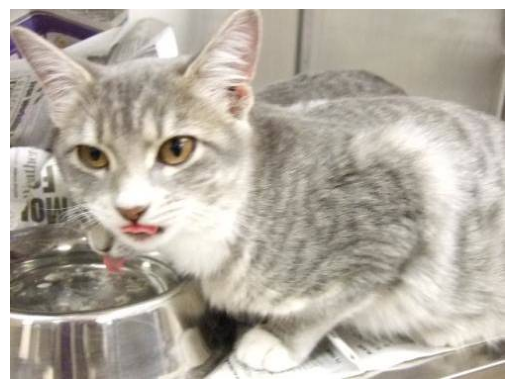

In [56]:
import os
import random
from pathlib import Path
from PIL import Image


test_dir = Path('/kaggle/input/reduced/dogs-vs-cats/test')

if not test_dir.exists():
    raise FileNotFoundError(f"Directory {test_dir} does not exist.")
all_files = list(test_dir.glob('*/*.jpg'))  
if not all_files:
    raise FileNotFoundError(f"No files found in directory {test_dir}.")

random_image_path = random.choice(all_files)

img = Image.open(random_image_path)

plt.imshow(img)
plt.axis('off')
plt.show()



## **ViT**

In [57]:
from transformers import AutoImageProcessor

vit_pretrained = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

pixel_values = vit_pretrained(images=img, return_tensors="pt").pixel_values

print(f"Pixel values tensor shape: {pixel_values.shape}")

Pixel values tensor shape: torch.Size([1, 3, 224, 224])


In [58]:
pixel_values

tensor([[[[ 0.4588,  0.4745,  0.4824,  ...,  0.2235,  0.1216,  0.0196],
          [ 0.4667,  0.4902,  0.5059,  ...,  0.2235,  0.1294,  0.0353],
          [ 0.4902,  0.5137,  0.5373,  ...,  0.2235,  0.1216,  0.0275],
          ...,
          [ 0.1451,  0.1294,  0.1529,  ...,  0.1922,  0.2078,  0.2157],
          [ 0.1529,  0.1373,  0.1608,  ...,  0.2157,  0.2235,  0.2235],
          [ 0.1686,  0.1451,  0.1608,  ...,  0.2392,  0.2235,  0.2157]],

         [[ 0.3882,  0.4039,  0.4196,  ...,  0.1765,  0.0745, -0.0275],
          [ 0.4039,  0.4275,  0.4431,  ...,  0.1765,  0.0824, -0.0118],
          [ 0.4275,  0.4510,  0.4745,  ...,  0.1765,  0.0745, -0.0196],
          ...,
          [ 0.0902,  0.0745,  0.0980,  ...,  0.0667,  0.0824,  0.0824],
          [ 0.0980,  0.0824,  0.1059,  ...,  0.0902,  0.0902,  0.0902],
          [ 0.1137,  0.0902,  0.1059,  ...,  0.1137,  0.0902,  0.0824]],

         [[ 0.4039,  0.4118,  0.4118,  ...,  0.0824, -0.0196, -0.1216],
          [ 0.3961,  0.4118,  

## **SWIN**

In [59]:
from transformers import AutoImageProcessor

swin = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
pixel_values = swin(images=img, return_tensors="pt").pixel_values

print(f"Pixel values tensor shape: {pixel_values.shape}")

Pixel values tensor shape: torch.Size([1, 3, 224, 224])


In [60]:
pixel_values

tensor([[[[1.0673, 1.1015, 1.1187,  ..., 0.5707, 0.3309, 0.0912],
          [1.0844, 1.1358, 1.1700,  ..., 0.5707, 0.3481, 0.1254],
          [1.1358, 1.1700, 1.2214,  ..., 0.5707, 0.3309, 0.1083],
          ...,
          [0.3823, 0.3309, 0.3994,  ..., 0.4851, 0.5193, 0.5364],
          [0.4166, 0.3481, 0.3994,  ..., 0.5364, 0.5536, 0.5536],
          [0.4508, 0.3823, 0.3994,  ..., 0.5878, 0.5536, 0.5364]],

         [[1.0630, 1.0980, 1.1331,  ..., 0.6078, 0.3627, 0.1176],
          [1.0805, 1.1506, 1.1856,  ..., 0.6078, 0.3803, 0.1527],
          [1.1506, 1.2031, 1.2556,  ..., 0.6078, 0.3627, 0.1352],
          ...,
          [0.3978, 0.3452, 0.4153,  ..., 0.3452, 0.3803, 0.3803],
          [0.4328, 0.3627, 0.4153,  ..., 0.3978, 0.3978, 0.3978],
          [0.4678, 0.3978, 0.4153,  ..., 0.4503, 0.3978, 0.3803]],

         [[1.3154, 1.3328, 1.3328,  ..., 0.6182, 0.3742, 0.1302],
          [1.2980, 1.3328, 1.3502,  ..., 0.6182, 0.3916, 0.1651],
          [1.2805, 1.3328, 1.3851,  ..., 0

## **PVT**

In [61]:
from transformers import AutoImageProcessor

pvt = AutoImageProcessor.from_pretrained("Zetatech/pvt-tiny-224")
pixel_values = pvt(images=img, return_tensors="pt").pixel_values

print(f"Pixel values tensor shape: {pixel_values.shape}")

Pixel values tensor shape: torch.Size([1, 3, 224, 224])


In [62]:
pixel_values

tensor([[[[1.0673, 1.1015, 1.1187,  ..., 0.5536, 0.3309, 0.1083],
          [1.0844, 1.1358, 1.1700,  ..., 0.5536, 0.3481, 0.1426],
          [1.1358, 1.1872, 1.2385,  ..., 0.5536, 0.3309, 0.1254],
          ...,
          [0.3823, 0.3481, 0.3994,  ..., 0.4851, 0.5193, 0.5364],
          [0.3994, 0.3652, 0.4166,  ..., 0.5364, 0.5536, 0.5536],
          [0.4337, 0.3823, 0.4166,  ..., 0.5878, 0.5536, 0.5364]],

         [[1.0630, 1.0980, 1.1331,  ..., 0.5903, 0.3627, 0.1352],
          [1.0980, 1.1506, 1.1856,  ..., 0.5903, 0.3803, 0.1702],
          [1.1506, 1.2031, 1.2556,  ..., 0.5903, 0.3627, 0.1527],
          ...,
          [0.3978, 0.3627, 0.4153,  ..., 0.3452, 0.3803, 0.3803],
          [0.4153, 0.3803, 0.4328,  ..., 0.3978, 0.3978, 0.3978],
          [0.4503, 0.3978, 0.4328,  ..., 0.4503, 0.3978, 0.3803]],

         [[1.3154, 1.3328, 1.3328,  ..., 0.6008, 0.3742, 0.1476],
          [1.2980, 1.3328, 1.3502,  ..., 0.6008, 0.3916, 0.1825],
          [1.2805, 1.3328, 1.3851,  ..., 0

## **CvT**

In [63]:
from transformers import AutoImageProcessor

CvT = AutoImageProcessor.from_pretrained("microsoft/cvt-13")
pixel_values = CvT(images=img, return_tensors="pt").pixel_values

print(f"Pixel values tensor shape: {pixel_values.shape}")

Pixel values tensor shape: torch.Size([1, 3, 224, 224])


In [64]:
pixel_values

tensor([[[[-0.8164, -0.4568,  0.0912,  ...,  1.0331,  1.0502,  1.0673],
          [ 0.1426,  0.8789,  1.4098,  ...,  1.0331,  1.0502,  1.0673],
          [ 1.6153,  1.8379,  1.8722,  ...,  1.0159,  1.0159,  1.0331],
          ...,
          [-0.3712, -0.3369, -0.3369,  ...,  2.1119,  2.0605,  2.0092],
          [-0.3027, -0.2171, -0.1828,  ...,  2.2318,  2.2318,  2.1975],
          [-0.1486, -0.1486, -0.0972,  ...,  2.2318,  2.2489,  2.2489]],

         [[-0.8803, -0.4951,  0.0651,  ...,  1.0805,  1.0980,  1.1155],
          [ 0.1176,  0.8880,  1.4307,  ...,  1.0805,  1.0980,  1.1155],
          [ 1.6408,  1.8683,  1.9384,  ...,  1.0630,  1.0630,  1.0805],
          ...,
          [-0.4076, -0.3725, -0.3901,  ...,  2.2710,  2.2185,  2.1660],
          [-0.3375, -0.2675, -0.2325,  ...,  2.3936,  2.3936,  2.3585],
          [-0.1800, -0.1975, -0.1450,  ...,  2.4111,  2.4286,  2.4286]],

         [[-0.3230, -0.0441,  0.4439,  ...,  1.0191,  1.0365,  1.0539],
          [ 0.6705,  1.3677,  

## **BEiT**

In [65]:
from transformers import AutoImageProcessor

BEiT = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
pixel_values = BEiT(images=img, return_tensors="pt").pixel_values

print(f"Pixel values tensor shape: {pixel_values.shape}")

Pixel values tensor shape: torch.Size([1, 3, 224, 224])


In [66]:
pixel_values

tensor([[[[ 0.4588,  0.4745,  0.4824,  ...,  0.2235,  0.1216,  0.0196],
          [ 0.4667,  0.4902,  0.5059,  ...,  0.2235,  0.1294,  0.0353],
          [ 0.4902,  0.5137,  0.5373,  ...,  0.2235,  0.1216,  0.0275],
          ...,
          [ 0.1451,  0.1294,  0.1529,  ...,  0.1922,  0.2078,  0.2157],
          [ 0.1529,  0.1373,  0.1608,  ...,  0.2157,  0.2235,  0.2235],
          [ 0.1686,  0.1451,  0.1608,  ...,  0.2392,  0.2235,  0.2157]],

         [[ 0.3882,  0.4039,  0.4196,  ...,  0.1765,  0.0745, -0.0275],
          [ 0.4039,  0.4275,  0.4431,  ...,  0.1765,  0.0824, -0.0118],
          [ 0.4275,  0.4510,  0.4745,  ...,  0.1765,  0.0745, -0.0196],
          ...,
          [ 0.0902,  0.0745,  0.0980,  ...,  0.0667,  0.0824,  0.0824],
          [ 0.0980,  0.0824,  0.1059,  ...,  0.0902,  0.0902,  0.0902],
          [ 0.1137,  0.0902,  0.1059,  ...,  0.1137,  0.0902,  0.0824]],

         [[ 0.4039,  0.4118,  0.4118,  ...,  0.0824, -0.0196, -0.1216],
          [ 0.3961,  0.4118,  

## **Preprocessing step**

In [67]:
def custom_data_collator(features):
    images, labels = zip(*features)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": images, "labels": labels}

In [68]:
# from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [69]:
def vit_preprocessing(image):
    inputs = vit_pretrained(images=image, return_tensors="pt")
    return inputs.pixel_values.squeeze(0) 

In [70]:
print(f"Validation dataset size: {len(val_dataloader.dataset)}")
print(f"Class names: {class_names}")

full_train_data = datasets.ImageFolder(train_dir)

train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

train_image_paths = [full_train_data.imgs[idx][0] for idx in train_data.indices]
train_labels = [full_train_data.imgs[idx][1] for idx in train_data.indices]

val_image_paths = [full_train_data.imgs[idx][0] for idx in val_data.indices]
val_labels = [full_train_data.imgs[idx][1] for idx in val_data.indices]

train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=vit_preprocessing)
val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=vit_preprocessing)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Validation dataset size: 200
Class names: ['cats', 'dogs']
Training dataset size: 1800
Validation dataset size: 200


## **Training for ViT Model**

In [71]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, DefaultDataCollator,TrainerCallback

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = (pred == labels).mean()
    return {"accuracy": accuracy}

In [72]:
model1 = {
    'ViT': 'google/vit-base-patch16-224-in21k'
}

In [73]:
results = {}
def get_model_and_args(model_name, model_url):
    model = AutoModelForImageClassification.from_pretrained(
        model_url,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./{model_name}_model",
        per_device_train_batch_size=4,
        evaluation_strategy="steps",
        num_train_epochs=5,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=100,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
    )

    return model, training_args

In [74]:
for model_name, model_url in model1.items():
    print(f"Training {model_name}...")
    model, training_args = get_model_and_args(model_name, model_url)
    
    vit_trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=custom_data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_results = vit_trainer.train()
    vit_trainer.save_model()
    vit_trainer.save_metrics("train", train_results.metrics)
    vit_trainer.save_state()
    
    # Evaluate the model
    eval_metrics = vit_trainer.evaluate(val_dataset)
    vit_trainer.log_metrics("eval", eval_metrics)
    vit_trainer.save_metrics("eval", eval_metrics)
    
    # Store results
    results[model_name] = (train_results.metrics, eval_metrics)

Training ViT...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.259500,0.386573,0.935000
200,0.357700,0.364454,0.960000
300,0.346400,0.851667,0.940000
400,0.284600,0.617373,0.960000
500,0.139400,0.811697,0.940000
600,0.180900,0.815280,0.945000
700,0.094900,0.662132,0.955000
800,0.053500,0.493659,0.970000
900,0.019600,0.530852,0.965000
1000,0.005700,0.476788,0.970000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.96
  eval_loss               =     0.3645
  eval_runtime            = 0:00:02.66
  eval_samples_per_second =     74.927
  eval_steps_per_second   =       4.87


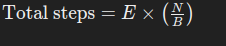

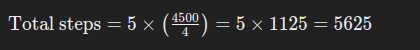

## **SWIN**

In [75]:
def swin_preprocessing(image):
    inputs = swin(images=image, return_tensors="pt")
    return inputs.pixel_values.squeeze(0) 

In [76]:

model2 = {
    'Swin': 'microsoft/swin-tiny-patch4-window7-224'
}


In [77]:
print(f"Validation dataset size: {len(val_dataloader.dataset)}")
print(f"Class names: {class_names}")

# Redefine the required variables based on create_dataloaders function output
full_train_data = datasets.ImageFolder(train_dir)

# Split training data into training and validation sets
train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Create image paths and labels lists for train and val datasets
train_image_paths = [full_train_data.imgs[idx][0] for idx in train_data.indices]
train_labels = [full_train_data.imgs[idx][1] for idx in train_data.indices]

val_image_paths = [full_train_data.imgs[idx][0] for idx in val_data.indices]
val_labels = [full_train_data.imgs[idx][1] for idx in val_data.indices]

# Create the datasets using CustomImageDataset
train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=swin_preprocessing)
val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=swin_preprocessing)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Validation dataset size: 200
Class names: ['cats', 'dogs']
Training dataset size: 1800
Validation dataset size: 200


In [78]:
results = {}
def get_model_and_args(model_name, model_url):
    model = AutoModelForImageClassification.from_pretrained(
        model_url,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./{model_name}_model",
        per_device_train_batch_size=4,
        evaluation_strategy="steps",
        num_train_epochs=5,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=100,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
    )

    return model, training_args


In [79]:
for model_name, model_url in model2.items():
    print(f"Training {model_name}...")
    model, training_args = get_model_and_args(model_name, model_url)
    
    swin_trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=custom_data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_results = swin_trainer.train()
    swin_trainer.save_model()
    swin_trainer.save_metrics("train", train_results.metrics)
    swin_trainer.save_state()
    
    # Evaluate the model
    eval_metrics = swin_trainer.evaluate(val_dataset)
    swin_trainer.log_metrics("eval", eval_metrics)
    swin_trainer.save_metrics("eval", eval_metrics)
    
    # Store results
    results[model_name] = (train_results.metrics, eval_metrics)

Training Swin...


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.530100,0.547430,0.955000
200,0.451200,0.950076,0.935000
300,0.460800,0.615096,0.960000
400,0.404100,0.544441,0.970000
500,0.213400,0.584647,0.975000
600,0.269700,0.513808,0.965000
700,0.211300,0.372124,0.975000
800,0.064300,0.407251,0.975000
900,0.081600,0.219435,0.985000
1000,0.000400,0.195618,0.990000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.99
  eval_loss               =     0.1956
  eval_runtime            = 0:00:02.31
  eval_samples_per_second =     86.343
  eval_steps_per_second   =      5.612


## **PvT**

In [80]:
def pvt_preprocessing(image):
    inputs = pvt(images=image, return_tensors="pt")
    return inputs.pixel_values.squeeze(0) 

In [81]:
print(f"Validation dataset size: {len(val_dataloader.dataset)}")
print(f"Class names: {class_names}")

# Redefine the required variables based on create_dataloaders function output
full_train_data = datasets.ImageFolder(train_dir)

# Split training data into training and validation sets
train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Create image paths and labels lists for train and val datasets
train_image_paths = [full_train_data.imgs[idx][0] for idx in train_data.indices]
train_labels = [full_train_data.imgs[idx][1] for idx in train_data.indices]

val_image_paths = [full_train_data.imgs[idx][0] for idx in val_data.indices]
val_labels = [full_train_data.imgs[idx][1] for idx in val_data.indices]

# Create the datasets using CustomImageDataset
train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=pvt_preprocessing)
val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=pvt_preprocessing)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Validation dataset size: 200
Class names: ['cats', 'dogs']
Training dataset size: 1800
Validation dataset size: 200


In [82]:
model3 = {
    'PvT' : "Zetatech/pvt-tiny-224"
}

In [83]:
results = {}
def get_model_and_args(model_name, model_url):
    model = AutoModelForImageClassification.from_pretrained(
        model_url,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./{model_name}_model",
        per_device_train_batch_size=4,
        evaluation_strategy="steps",
        num_train_epochs=5,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=100,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
    )

    return model, training_args


In [84]:
for model_name, model_url in model3.items():
    print(f"Training {model_name}...")
    model, training_args = get_model_and_args(model_name, model_url)
    
    pvt_trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=custom_data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_results = pvt_trainer.train()
    pvt_trainer.save_model()
    pvt_trainer.save_metrics("train", train_results.metrics)
    pvt_trainer.save_state()
    
    # Evaluate the model
    eval_metrics = pvt_trainer.evaluate(val_dataset)
    pvt_trainer.log_metrics("eval", eval_metrics)
    pvt_trainer.save_metrics("eval", eval_metrics)
    
    # Store results
    results[model_name] = (train_results.metrics, eval_metrics)

Training PvT...


Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.285100,0.410766,0.930000
200,0.493700,0.982747,0.910000
300,0.347400,1.099998,0.930000
400,0.186900,0.787105,0.935000
500,0.103900,0.791350,0.950000
600,0.063000,0.520838,0.965000
700,0.061900,0.614523,0.950000
800,0.023200,0.657579,0.955000
900,0.000000,0.565365,0.960000
1000,0.000000,0.568858,0.960000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.93
  eval_loss               =     0.4108
  eval_runtime            = 0:00:01.84
  eval_samples_per_second =    108.374
  eval_steps_per_second   =      7.044


## **CvT**

In [85]:
def cvt_preprocessing(image):
    inputs = CvT(images=image, return_tensors="pt")
    return inputs.pixel_values.squeeze(0)

In [86]:
print(f"Validation dataset size: {len(val_dataloader.dataset)}")
print(f"Class names: {class_names}")

# Redefine the required variables based on create_dataloaders function output
full_train_data = datasets.ImageFolder(train_dir)

# Split training data into training and validation sets
train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Create image paths and labels lists for train and val datasets
train_image_paths = [full_train_data.imgs[idx][0] for idx in train_data.indices]
train_labels = [full_train_data.imgs[idx][1] for idx in train_data.indices]

val_image_paths = [full_train_data.imgs[idx][0] for idx in val_data.indices]
val_labels = [full_train_data.imgs[idx][1] for idx in val_data.indices]

# Create the datasets using CustomImageDataset
train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=cvt_preprocessing)
val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=cvt_preprocessing)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Validation dataset size: 200
Class names: ['cats', 'dogs']
Training dataset size: 1800
Validation dataset size: 200


In [87]:
model4 = {
    'CvT' : "microsoft/cvt-13"
}

In [88]:
results = {}
def get_model_and_args(model_name, model_url):
    model = AutoModelForImageClassification.from_pretrained(
        model_url,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./{model_name}_model",
        per_device_train_batch_size=4,
        evaluation_strategy="steps",
        num_train_epochs=5,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=100,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
    )

    return model, training_args


In [89]:
for model_name, model_url in model4.items():
    print(f"Training {model_name}...")
    model, training_args = get_model_and_args(model_name, model_url)
    
    cvt_trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=custom_data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_results = cvt_trainer.train()
    cvt_trainer.save_model()
    cvt_trainer.save_metrics("train", train_results.metrics)
    cvt_trainer.save_state()
    
    # Evaluate the model
    eval_metrics = cvt_trainer.evaluate(val_dataset)
    cvt_trainer.log_metrics("eval", eval_metrics)
    cvt_trainer.save_metrics("eval", eval_metrics)
    
    # Store results
    results[model_name] = (train_results.metrics, eval_metrics)

Training CvT...


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.308400,0.068291,0.980000
200,0.341700,0.338855,0.950000
300,0.350600,0.307837,0.955000
400,0.323600,0.221312,0.975000
500,0.339300,0.116769,0.990000
600,0.268900,0.259949,0.965000
700,0.300000,0.072823,0.995000
800,0.194700,0.143564,0.985000
900,0.165800,0.069516,0.990000
1000,0.151400,0.208645,0.975000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.98
  eval_loss               =     0.0683
  eval_runtime            = 0:00:02.69
  eval_samples_per_second =     74.268
  eval_steps_per_second   =      4.827


## **BEiT**

In [90]:
def beit_preprocessing(image):
    inputs = BEiT(images=image, return_tensors="pt")
    return inputs.pixel_values.squeeze(0)

In [91]:
print(f"Validation dataset size: {len(val_dataloader.dataset)}")
print(f"Class names: {class_names}")

# Redefine the required variables based on create_dataloaders function output
full_train_data = datasets.ImageFolder(train_dir)

# Split training data into training and validation sets
train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

# Create image paths and labels lists for train and val datasets
train_image_paths = [full_train_data.imgs[idx][0] for idx in train_data.indices]
train_labels = [full_train_data.imgs[idx][1] for idx in train_data.indices]

val_image_paths = [full_train_data.imgs[idx][0] for idx in val_data.indices]
val_labels = [full_train_data.imgs[idx][1] for idx in val_data.indices]

# Create the datasets using CustomImageDataset
train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=beit_preprocessing)
val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=beit_preprocessing)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Validation dataset size: 200
Class names: ['cats', 'dogs']
Training dataset size: 1800
Validation dataset size: 200


In [92]:
model5 = {
    'BEiT' : "microsoft/beit-base-patch16-224-pt22k"
}

In [93]:
results = {}
def get_model_and_args(model_name, model_url):
    model = AutoModelForImageClassification.from_pretrained(
        model_url,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    training_args = TrainingArguments(
        output_dir=f"./{model_name}_model",
        per_device_train_batch_size=4,
        evaluation_strategy="steps",
        num_train_epochs=5,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=100,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
    )

    return model, training_args


In [94]:
for model_name, model_url in model5.items():
    print(f"Training {model_name}...")
    model, training_args = get_model_and_args(model_name, model_url)
    
    beit_trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=custom_data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_results = beit_trainer.train()
    beit_trainer.save_model()
    beit_trainer.save_metrics("train", train_results.metrics)
    beit_trainer.save_state()
    
    # Evaluate the model
    eval_metrics = beit_trainer.evaluate(val_dataset)
    beit_trainer.log_metrics("eval", eval_metrics)
    beit_trainer.save_metrics("eval", eval_metrics)
    
    # Store results
    results[model_name] = (train_results.metrics, eval_metrics)

Training BEiT...


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.792100,0.922501,0.530000
200,0.750100,0.689463,0.540000
300,0.720500,0.693500,0.540000
400,0.697900,0.676534,0.625000
500,0.670400,0.702551,0.535000
600,0.654200,0.650345,0.645000
700,0.692000,0.643380,0.625000
800,0.622600,0.707134,0.650000
900,0.647300,0.624982,0.665000
1000,0.567000,0.650124,0.640000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.665
  eval_loss               =      0.625
  eval_runtime            = 0:00:02.73
  eval_samples_per_second =     73.238
  eval_steps_per_second   =       4.76


In [ ]:
results = {}

def extract_accuracy(metrics):
    return metrics["eval_accuracy"] if "eval_accuracy" in metrics else None

def train_and_evaluate_model(model_name, model_url):
    print(f"Training {model_name}...")
    model, training_args = get_model_and_args(model_name, model_url)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=custom_data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    train_results = trainer.train()
    trainer.save_model()
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()
    
    # Evaluate the model
    eval_metrics = trainer.evaluate(val_dataset)
    trainer.log_metrics("eval", eval_metrics)
    trainer.save_metrics("eval", eval_metrics)
    
    # Store results
    results[model_name] = {
        "train_metrics": train_results.metrics,
        "eval_metrics": eval_metrics
    }
    
    return extract_accuracy(eval_metrics)

model_names = []
eval_accuracies = []

for model_name, model_url in model1.items():
    accuracy = train_and_evaluate_model(model_name, model_url)
    model_names.append(model_name)
    eval_accuracies.append(accuracy)

for model_name, model_url in model2.items():
    accuracy = train_and_evaluate_model(model_name, model_url)
    model_names.append(model_name)
    eval_accuracies.append(accuracy)

for model_name, model_url in model3.items():
    accuracy = train_and_evaluate_model(model_name, model_url)
    model_names.append(model_name)
    eval_accuracies.append(accuracy)

for model_name, model_url in model4.items():
    accuracy = train_and_evaluate_model(model_name, model_url)
    model_names.append(model_name)
    eval_accuracies.append(accuracy)

for model_name, model_url in model5.items():
    accuracy = train_and_evaluate_model(model_name, model_url)
    model_names.append(model_name)
    eval_accuracies.append(accuracy)

df = pd.DataFrame({
    "Model Name": model_names,
    "Evaluation Accuracy": eval_accuracies
})



Training ViT...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.254500,0.498856,0.905000
200,0.373300,0.466376,0.950000
300,0.300200,0.986051,0.930000
400,0.232100,0.504919,0.965000
500,0.171500,0.448483,0.970000
600,0.045300,0.534727,0.965000
700,0.016200,0.390561,0.975000
800,0.020900,0.250789,0.985000
900,0.020300,0.251689,0.985000
1000,0.000000,0.251990,0.985000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.985
  eval_loss               =     0.2508
  eval_runtime            = 0:00:02.61
  eval_samples_per_second =     76.578
  eval_steps_per_second   =      4.978
Training Swin...


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.607600,0.402658,0.960000
200,0.819500,0.488527,0.960000
300,0.496500,2.529338,0.855000
400,0.459000,0.463889,0.960000
500,0.365500,0.294358,0.980000
600,0.128200,0.542547,0.965000
700,0.154700,0.101359,0.995000
800,0.085500,0.355549,0.980000
900,0.069700,0.360790,0.980000
1000,0.000000,0.530343,0.970000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.995
  eval_loss               =     0.1014
  eval_runtime            = 0:00:02.03
  eval_samples_per_second =     98.371
  eval_steps_per_second   =      6.394
Training PvT...


Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.396700,0.663197,0.910000
200,0.613100,1.071593,0.890000
300,0.585900,1.049093,0.925000
400,0.522200,0.963542,0.930000
500,0.342300,0.496358,0.970000
600,0.096900,0.702533,0.955000
700,0.145200,0.485050,0.965000
800,0.019500,0.597598,0.955000
900,0.000000,0.531236,0.960000
1000,0.000000,0.512122,0.965000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =      0.965
  eval_loss               =      0.485
  eval_runtime            = 0:00:01.80
  eval_samples_per_second =    110.863
  eval_steps_per_second   =      7.206
Training CvT...


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([2, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.319600,0.142389,0.955000
200,0.331800,0.140542,0.970000
300,0.293300,0.269088,0.960000
400,0.291500,0.298503,0.975000
500,0.356300,0.374098,0.970000
600,0.207500,0.247589,0.980000
700,0.225900,0.291814,0.965000
800,0.214700,0.486412,0.965000
900,0.182200,0.236226,0.975000
1000,0.167600,0.252450,0.975000


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.97
  eval_loss               =     0.1405
  eval_runtime            = 0:00:02.34
  eval_samples_per_second =     85.436
  eval_steps_per_second   =      5.553
Training BEiT...


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.854600,0.820963,0.530000
200,0.722600,0.678576,0.580000
300,0.722000,0.678396,0.560000
400,0.694300,0.702176,0.475000


In [ ]:
df